In [1]:
from datacube import *
import masks as mask
import extras as ex
import flow_fields as ff
import director_field as director
import plot_functions as plot
%load_ext autoreload
%autoreload 2

In [2]:
# Pytorch setup 
cuda = torch.device('cuda')
torch.cuda.get_device_name(cuda)

'TITAN V'

## Parameters

In [3]:
# Microscope parameters
dx = 1.924   # Pixel resolution (angstrom /pixel) - UPDATED from 1.94873

# Image processing parameters
N = 32   # Size of nano-image in pixels
NN = 128   # size of FFT
step_size = 8

# Material system parameters
q = 0.28
d = (2 * math.pi)/q

sigma_q = 0.05   # desired q bandwidth
sigma_th = 0.01   # desired theta bandwidth

#Angles
angles = np.linspace(-80, 90, 18)
# angles = np.linspace(-89, 90, 180)
# angles = np.linspace(-85, 90, 36)
# print(angles)

# Contour lines for fourier transforms
q_contour = np.linspace(0.2, 0.5, 4)

## Plot HRTEM

In [4]:
pwd = '/home/camila/hrtem_rawData/20190714_Bao_A01_NN/'
fn = 'A01_NN_mosaic4_00010.mrc'

data = read_mrc(pwd + fn)
print(data.shape)

(24, 3838, 3710)


hrtem_tensor is tensor?: True
sending tensor to GPU


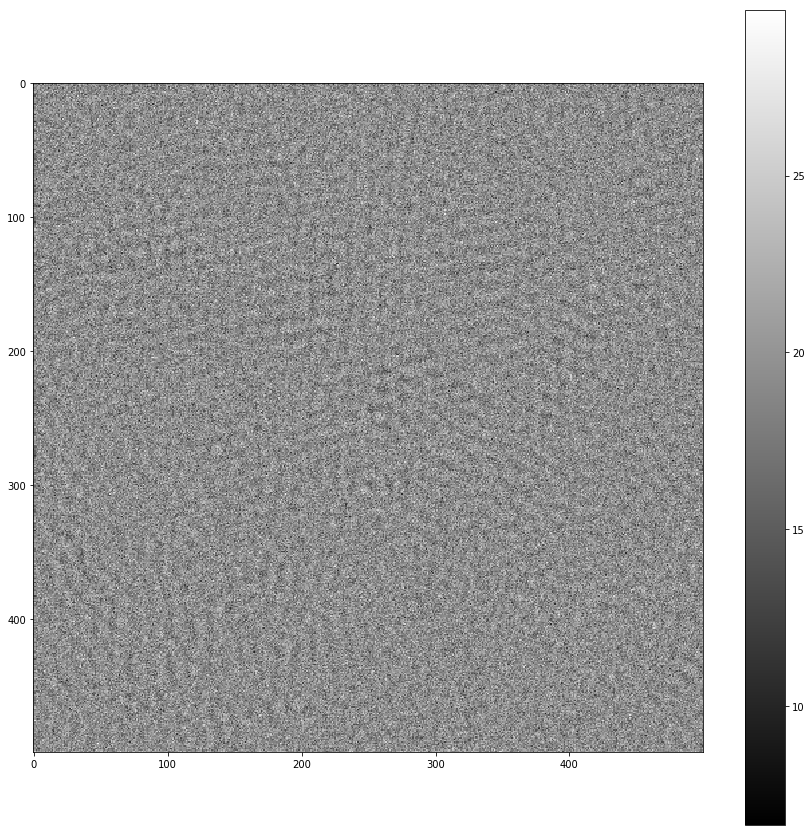

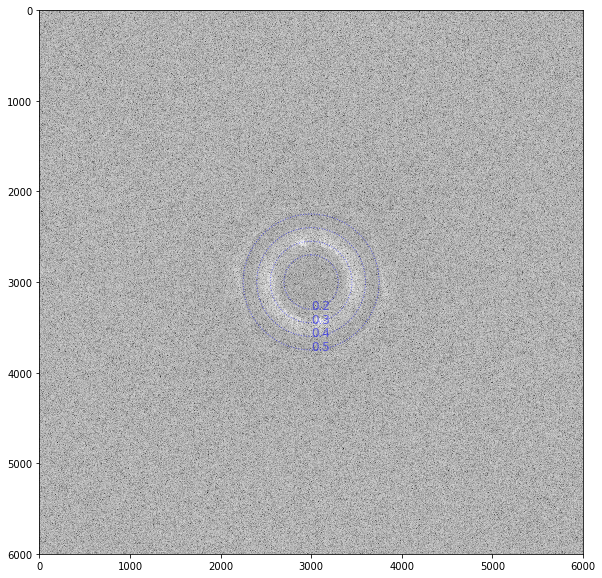

In [5]:
stack_range = 4
stack_data = stack_image(data[:stack_range, :, :])

img_size = 500
img_np = stack_image(data[:stack_range, :, :])[-img_size:, -img_size:]
# img_np = stack_image(data[:stack_range, :, :])

# get hrtem image tensor. 
# NOTE: tensor and numpy share the same memory in CPU!
img_tensor = torch.from_numpy(img_np)
print('hrtem_tensor is tensor?: ' + str(torch.is_tensor(img_tensor)))

print('sending tensor to GPU')
img_tensor_gpu = img_tensor.to(cuda)   # tensor send to gpu not related in memory to numpy

plot.hrtem(img_np, gamma=0.5)

img_fft_gpu = tensor_fft(normalize_tensor(img_tensor_gpu), s=6000)
plot.fft(np.log(img_fft_gpu.cpu())**2, 6000, q_contour)

## Generate Gaussian filter at set spacing (q) and bandwidth (sigma_q, sigma_th)

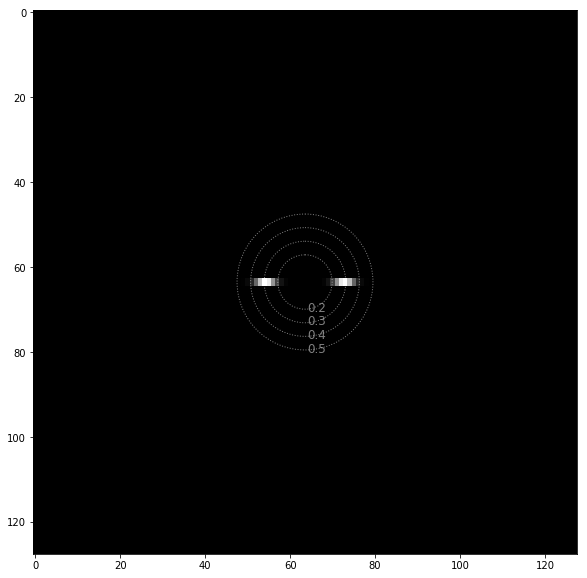

In [6]:
#### Gaussian q filter (no rotation):
gaussian_q_filter = mask.gaussian_q_filter(q, sigma_q, sigma_th, N, NN, dx)
plot.fft(gaussian_q_filter, NN, q_contour, 'white')

## Extract 4D datacube by performing nano FFT using a sliding window

In [7]:
# Time estimation --> 55x speed increase when using PyTorch
operations = ((img_tensor_gpu.shape[0] - N)/step_size + 1)**2
operation_rate = 7.4/14884
print("number of operations to performed - big O = n^2: " + str(operations))
print('expected operation time [seconds]: ' + str(np.round(operations*operation_rate,1)) + '\n ........... running .............')

output_fn = 'bla.npy'
img_datacube = get_datacube(img_tensor_gpu, angles, step_size, q, output_fn, sigma_q, sigma_th, N, NN, device='cuda', dx=dx, plot=False)
# img_datacube_median = median_filter(img_datacube, device=cuda, size=5)   # not needed because doing median filter later. Doing twice is redundant

number of operations to performed - big O = n^2: 3540.25
expected operation time [seconds]: 1.8
 ........... running .............
row:  0
row:  50
Processing time to get 4D datacube [seconds]: 1.8109800815582275


## Load dark reference (background)

In [8]:
percentile_factor = 5
pwd = '/home/camila/PycharmProjects/2019_may/dark_references/'

m, n, k = img_datacube.shape
background_mean_tensor = torch.mean(torch.from_numpy(np.load(pwd + 'df_angular_mean.npy')).to(cuda)[:m, :n, :], dim=2, keepdim=True)
background_std_tensor = torch.mean(torch.from_numpy(np.load(pwd + 'df_angular_std.npy')).to(cuda)[:m, :n, :], dim=2, keepdim=True)

print('4D datacube shape: (' + str(m) + ', ' + str(n) + ', ' + str(k) + ')')
print('mean of dark reference shape: ' + str(background_mean_tensor.shape))

4D datacube shape: (59, 59, 18)
mean of dark reference shape: torch.Size([59, 59, 1])


## Extract from datacube orientation map and intensity vs theta map

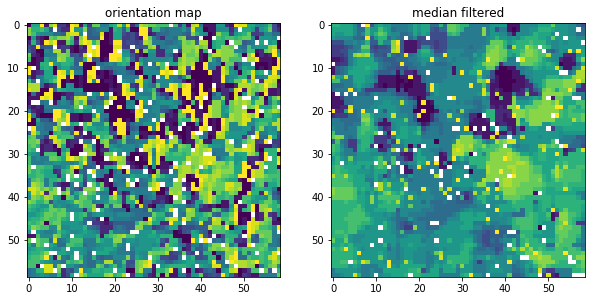

In [9]:
orientation_map_df, intensity_map_tensor = search_peaks(img_datacube, background_mean_tensor, background_std_tensor, percentile_factor, angles)

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(orientation_map_df)
plt.title('orientation map')

filter_size =5
orientation_map_df = median_filter(orientation_map_df, size=filter_size)
intensity_map_tensor = median_filter(intensity_map_tensor, size=filter_size)

plt.subplot(1,2,2)
plt.imshow(orientation_map_df)
plt.title('median filtered')
plt.show()

Seeding Flow Lines...


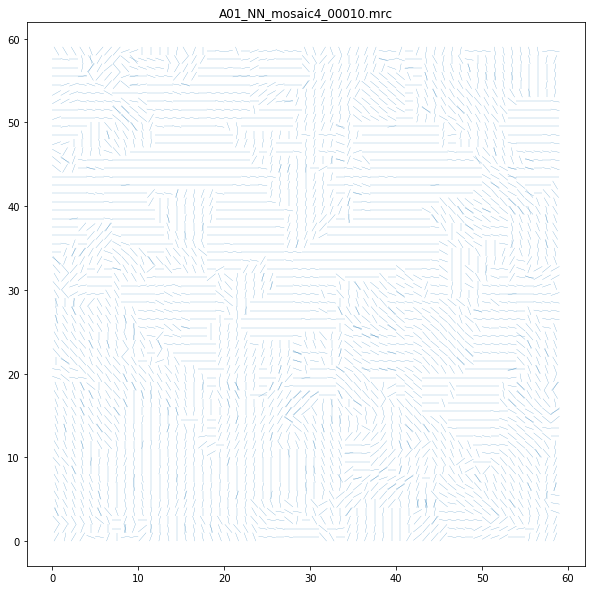

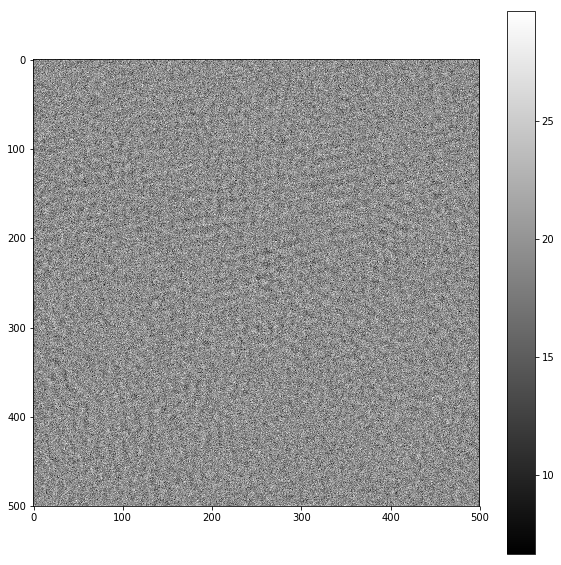

In [10]:
print('Seeding Flow Lines...')
line_seeds, peak_matrix = ff.seed_lines(ndimage.rotate(intensity_map_tensor.cpu().numpy(), -90), maxes_only=False, min_spacing=10)
ff.preview_line_plot(line_seeds, (10, 10))
directors = plt.gcf()
plt.title(fn)
# plt.savefig(pwd + 'seed_lines_' + fn[:-4] + '.tif')
plt.show()

plot.hrtem(img_np, size=10, gamma=0.5)

Propagating Flow Lines...
0%
5 %            0:00  remaining
10 %            0:00  remaining
15 %            0:00  remaining
20 %            0:00  remaining
25 %            0:00  remaining
30 %            0:00  remaining
35 %            0:00  remaining
40 %            0:00  remaining
45 %            0:00  remaining
50 %            0:00  remaining
55 %            0:00  remaining
60 %            0:00  remaining
65 %            0:00  remaining
70 %            0:00  remaining
75 %            0:00  remaining
80 %            0:00  remaining
85 %            0:00  remaining
90 %            0:00  remaining
95 %            0:00  remaining
Finished in  0:00
100 %            0:00  remaining
Total Time  0:00


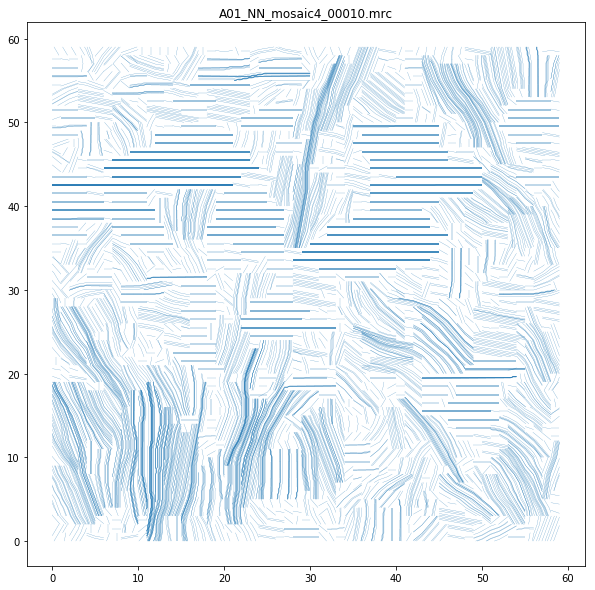

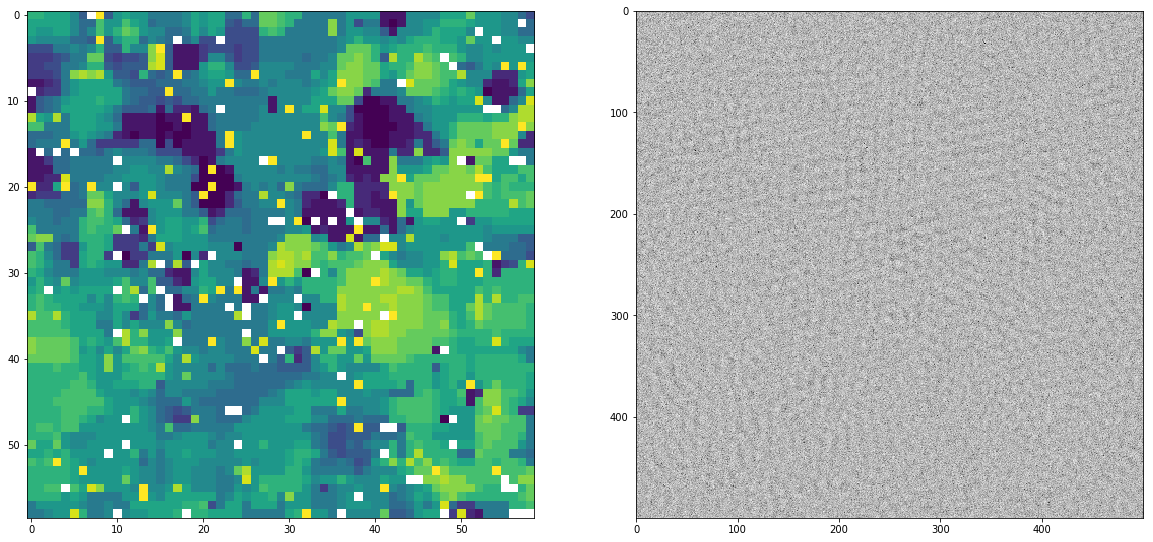

In [11]:
print('Propagating Flow Lines...')
progress_bar = ex.ProgressBar(len(line_seeds))
for line in line_seeds:
    line.propagate_2(peak_matrix, bend_tolerance=10)
    progress_bar.update('+1')

ff.preview_line_plot(line_seeds, (10,10))
propagated = plt.gcf()
plt.title(fn)
# plt.savefig(pwd + 'flow_lines_' + fn[:-4] + '.tif')
plt.show()

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(orientation_map_df)
plt.subplot(1,2,2)
plt.imshow(np.log(img_tensor_gpu.cpu().numpy()), cmap='gray')
plt.show()

Trimming Lines...


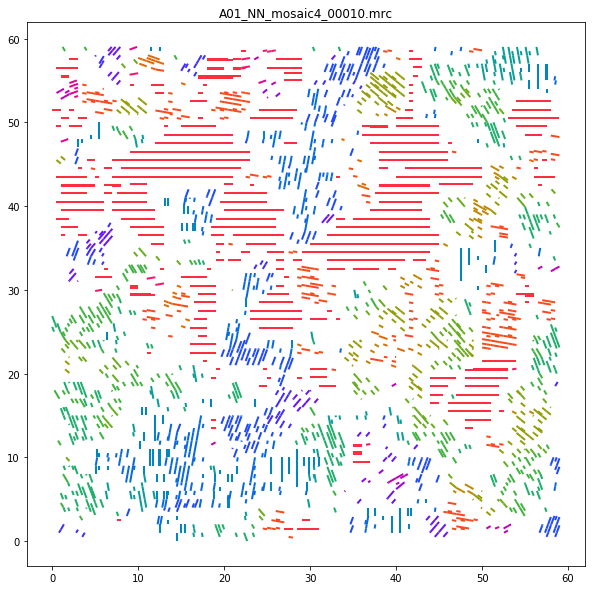

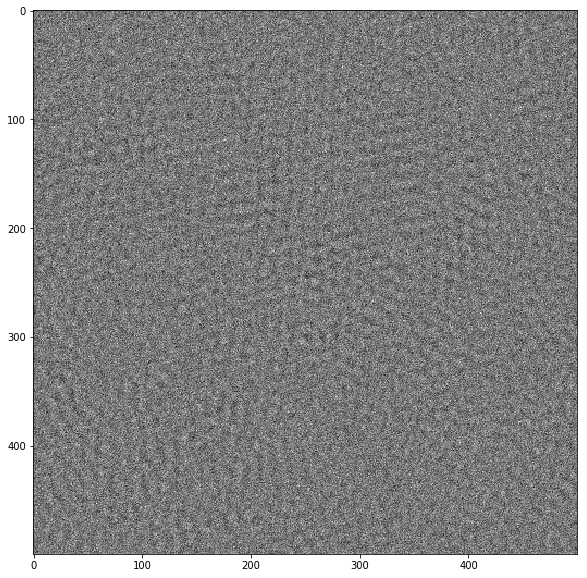

In [13]:
min_length = 2  # Must pass outside origninal box to be drawn
window_shape = (20, 60, 20, 60)
window = False

ff.trim_and_color(line_seeds, peak_matrix, min_length, (10, 10), window=window, window_shape=window_shape)
flow_field = plt.gcf()
plt.title(fn)
plt.savefig('test.tif')
plt.show()

plot.hrtem(img_np, size=10, gamma=0.75, colorbar=False)

Trimming Lines...


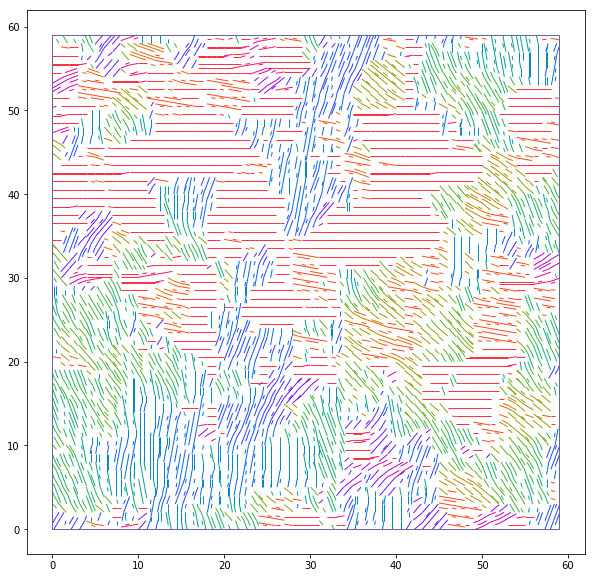

In [15]:
ff.trim_and_color(line_seeds, peak_matrix, min_length, (10, 10), window=window, window_shape=window_shape, intensities=False)
unweighted_flow_field = plt.gcf()
plt.show()